In [3]:
zin = z
theta_arr = theta_bins
bg=1
bI=1
dIdz=1
zbinedges=None

zin = np.array(zin)

from astropy import units as u
from astropy import cosmology
from astropy import constants as const
cosmo = cosmology.Planck15

theta_bins_arcsec = theta_arr
theta_bins_rad = (theta_bins_arcsec * u.arcsec).to(u.rad).value # rad

if zbinedges is None:
    zbinedges = np.arange(0,1.1,0.1)
zbins = (zbinedges[1:] + zbinedges[:-1]) / 2
dz = zbinedges[1] - zbinedges[0]

kbinedges = np.logspace(-3, 3, 1000) #[h/Mpc]
kbins = np.sqrt(kbinedges[:-1] * kbinedges[1:])
dk = kbinedges[1:] - kbinedges[:-1]

chis = (cosmo.comoving_distance(zbins)*cosmo.h).value # [Mpc/h]
dzdchis = (cosmo.H(zbins)/const.c/cosmo.h).to(1/u.Mpc).value # [h/Mpc]
Plins = []
for z in zbins:
    cosmo_power = cosmology_power_spectrum(z=z,k=kbins)
    Plin = cosmo_power.linear_power #[h^-3/Mpc^3]
    Plins.append(Plin)
Plins = np.array(Plins)

Nis,_ = np.histogram(zin, bins=zbinedges)
fis = Nis / np.sum(Nis)

# w_arr = np.zeros_like(theta_bins_arcsec)
# for ith, th in enumerate(theta_bins_rad):
#     zints = []
#     for ik, k in enumerate(kbins):
#         zint = np.sum(dzdchis * fis * Plins[:,ik] * scipy.special.jv(0, chis*k*th))
#         zints.append(zint)
#     zints = np.array(zints)

#     w_arr[ith] = np.sum(dk * kbins * zints) / 2 / np.pi

# Correlation Functions

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in greater_equal
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in less
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in greater_equal
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in less


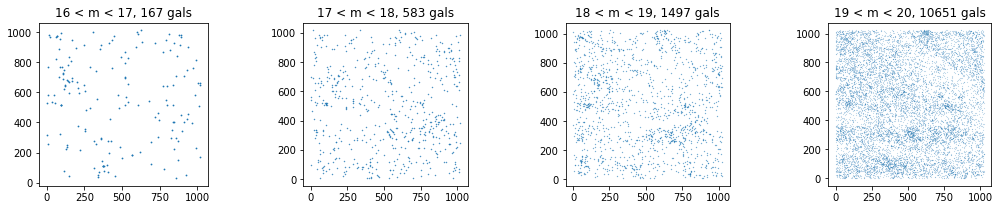

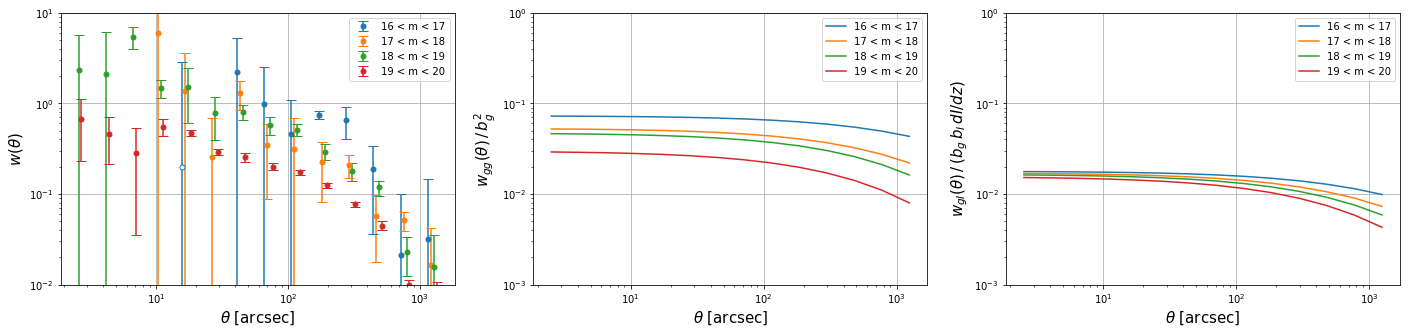

In [24]:
from astropy import units as u
from utils import *
from clustering import *

inst = 1
ifield = 8

fig, ax = plt.subplots(1, 4, figsize = (18,3))
fig1, ax1 = plt.subplots(1,3,figsize=(24,5))

theta_binedges_arcsec = np.logspace(0.3,3.2,15) # arcsec
theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])
for im in range(4):
    m_min = magbindict['m_min'][im]
    m_max = magbindict['m_max'][im]
    xoff = 1 + (im-1.5)*0.05
    
    cat_data = get_catalog(inst, ifield, im)

    z = cat_data['z']
    ra = cat_data['ra']
    dec = cat_data['dec']
    x = cat_data['x']
    y = cat_data['y']
    Ngal = len(z)
    
    ax[im].scatter(x, y, s= 100/Ngal)
    ax[im].set_title('%d < m < %d, %d gals'%(m_min,m_max,Ngal))
    ax[im].set_aspect(1)

    corr, dcorr, _ = get_angular_2pt_func(ra, dec, theta_binedges_deg, nboot=5)
    wgg_arr = wgg(z, theta_bins)
    wgI_arr = wgI(z, theta_bins)
    
    ax1[0].errorbar(theta_bins[corr>=0]*xoff, corr[corr>=0], dcorr[corr>=0],
                fmt='.', color='C'+str(im),capsize=5, markersize=10,
                 label='%d < m < %d'%(m_min,m_max))
    ax1[0].errorbar(theta_bins[corr<0]*xoff, -corr[corr<0], dcorr[corr<0],
                fmt='.', mfc='white', color='C'+str(im),capsize=5, markersize=10)
    
    ax1[1].loglog(theta_bins, wgg_arr, c='C'+str(im), label='%d < m < %d'%(m_min,m_max))
    ax1[2].loglog(theta_bins, wgI_arr, c='C'+str(im), label='%d < m < %d'%(m_min,m_max))

ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax1[0].set_ylabel(r'$w(\theta)$', fontsize=15)
ax1[0].set_ylim([1e-2,1e1])
ax1[0].grid()
ax1[0].legend()

ax1[1].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax1[1].set_ylabel(r'$w_{gg}(\theta)\,/\,b_g^2$', fontsize=15)
ax1[1].set_ylim([1e-3,1e0])
ax1[1].grid()
ax1[1].legend()

ax1[2].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax1[2].set_ylabel(r'$w_{gI}(\theta)\,/\,(b_g\,b_I\,dI/dz)$', fontsize=15)
ax1[2].set_ylim([1e-3,1e0])
ax1[2].grid()
ax1[2].legend()

fig.savefig('plots/galmaps.png', dpi = 150, bbox_inches='tight')
fig1.savefig('plots/wgg.png', dpi = 150, bbox_inches='tight')

## Comparing $w_{gI}$ to thin-shell approx

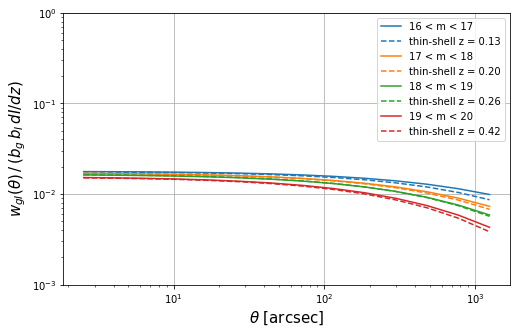

In [14]:
from astropy import units as u
from utils import *
from clustering import *

inst = 1
ifield = 8

fig, ax = plt.subplots(1,1,figsize=(8,5))

theta_binedges_arcsec = np.logspace(0.3,3.2,15) # arcsec
theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])
for im in range(4):
    m_min = magbindict['m_min'][im]
    m_max = magbindict['m_max'][im]
    xoff = 1 + (im-1.5)*0.05
    
    cat_data = get_catalog(inst, ifield, im)
    wgI_arr = wgI(cat_data['z'], theta_bins)
    zm = magbindict['zmean'][im]
    wgI_approx_arr = wgI_zm_approx(zm, theta_bins)
    
    ax.loglog(theta_bins, wgI_arr, c='C'+str(im), label='%d < m < %d'%(m_min,m_max))
    ax.loglog(theta_bins, wgI_approx_arr, c='C'+str(im), ls='--',label='thin-shell z = %.2f'%(zm))

ax.set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
ax.set_ylabel(r'$w_{gI}(\theta)\,/\,(b_g\,b_I\,dI/dz)$', fontsize=15)
ax.set_ylim([1e-3,1e0])
ax.grid()
ax.legend()

# Helgason dI/dz

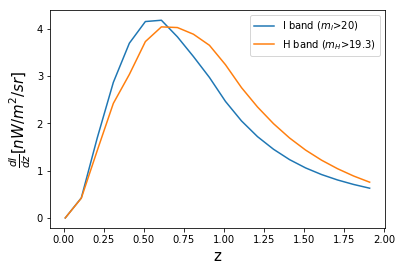

In [18]:
from Helgason import *
from utils import *

nu_sampled = np.array([1.05, 1.79])
z_sampled = np.arange(0.01,2,0.1)
dIdz_sampled = np.zeros((len(nu_sampled),len(z_sampled)))
dM = 0.1
M_arr = np.arange(-25,-17,dM)

for iz,z in enumerate(z_sampled):
    dV = ((3e5 * u.km / u.second) / cosmo.H(z) * cosmo.comoving_distance(z)**2).value # [Mpc^3]
    m_arr = - 2.5 * np.log10(1+z) + M_arr + \
    5 * np.log10((cosmo.luminosity_distance(z) / (10e-6*u.Mpc)).value)
    spI = np.where(m_arr>20)[0]
    spH = np.where(m_arr>19.3)[0]
    lambda_arr = []
    dIdzI_arr = []
    dIdzH_arr = []
    for bandidx in range(12):
        params = bands_class(bandidx)
        lambda_obs = params.wleff * (1+z)
        nu_obs = 3e14 / lambda_obs # [Hz]
        phi_arr = Helgason_LF(z, M_arr, bandidx)
        vFv_arr = nu_obs * 3631*10**(-m_arr/2.5) * 1e-17 #[nW/m^2]
        dIdzI = np.sum(phi_arr[spI] * vFv_arr[spI] * dV) * dM
        dIdzH = np.sum(phi_arr[spH] * vFv_arr[spH] * dV) * dM
        lambda_arr.append(lambda_obs)
        dIdzI_arr.append(dIdzI)
        dIdzH_arr.append(dIdzH)
    fI=scipy.interpolate.InterpolatedUnivariateSpline(lambda_arr, dIdzI_arr, k=1)
    fH=scipy.interpolate.InterpolatedUnivariateSpline(lambda_arr, dIdzH_arr, k=1)
    dIdz_sampled[0,iz] = fI(nu_sampled[0])
    dIdz_sampled[1,iz] = fH(nu_sampled[1])

plt.plot(z_sampled,dIdz_sampled[0], label='I band ($m_I$>20)')
plt.plot(z_sampled,dIdz_sampled[1], label='H band ($m_H$>19.3)')
plt.xlabel('z', fontsize=15)
plt.ylabel(r"$\frac{dI}{dz}[nW/m^2/sr]$",fontsize=15)
plt.legend()
plt.savefig('/Users/ytcheng/Desktop/dIdz.png', dpi = 150, bbox_inches='tight')

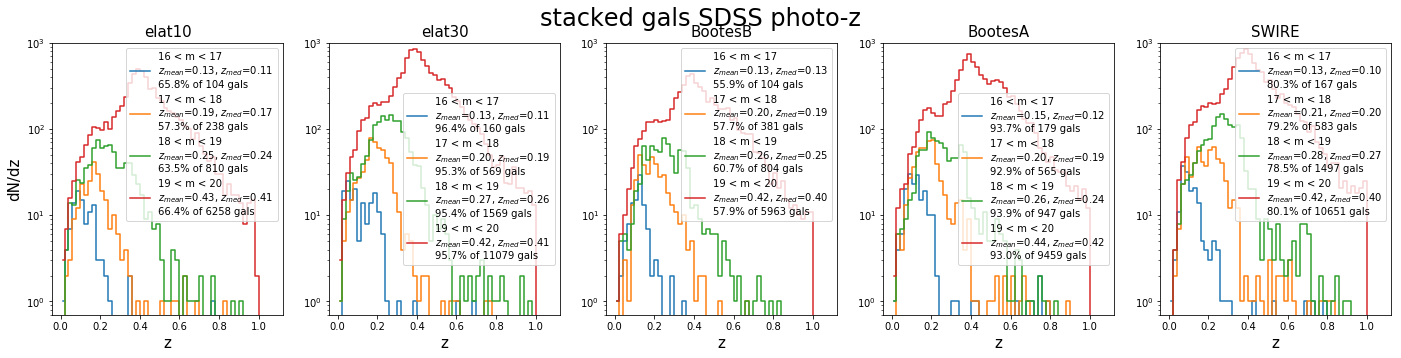

In [19]:
from astropy import units as u
from ciber_info import *

fig, ax = plt.subplots(1, 5, figsize = (24,5))
for i,ifield in enumerate([4,5,6,7,8]):
    field = fieldnamedict[ifield]
    fname = mypaths['PScatdat']+ field + '.csv'
    df = pd.read_csv(fname)

    binedges = np.arange(0,1.1,0.02)
    bins = (binedges[1:] + binedges[:-1]) / 2

    inst=1
    for im in range(4):
        m_min = im + 16
        m_max = im + 17
        dfi = df.loc[(df['sdssClass']==3) \
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['y'+str(inst)]>-0.5) & (df['y'+str(inst)]<1023.5)\
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['I_comb']>=m_min) & (df['I_comb']<m_max)]
        Nall = len(dfi)
        dfi = dfi.loc[dfi['Photz']>0]
        f = len(dfi)/Nall

        z = np.array(dfi['Photz'])
        ra = np.array(dfi['ra'])
        dec = np.array(dfi['dec'])

        meanz = np.mean(z)
        medianz = np.median(z)
        h,_ = np.histogram(z, bins=binedges)
        ax[i].step(bins,h, where='mid', 
                 label='%d < m < %d\n'%(m_min,m_max) + \
                   r'$z_{mean}$=%.2f, $z_{med}$=%.2f'%(meanz, medianz) + \
                   '\n%.1f%% of %d gals'%(f*100,len(z)))
    ax[i].set_ylim([7e-1, 1e3])
    ax[i].set_xlabel('z', fontsize=15)
    ax[i].set_title('%s'%field, fontsize=15)
    ax[i]
    ax[i].legend()
    ax[i].set_yscale('log')
ax[0].set_ylabel('dN/dz', fontsize=15)
fig.suptitle('stacked gals SDSS photo-z', fontsize=24)
plt.savefig('/Users/ytcheng/Desktop/z_kernel.png', dpi = 150, bbox_inches='tight')

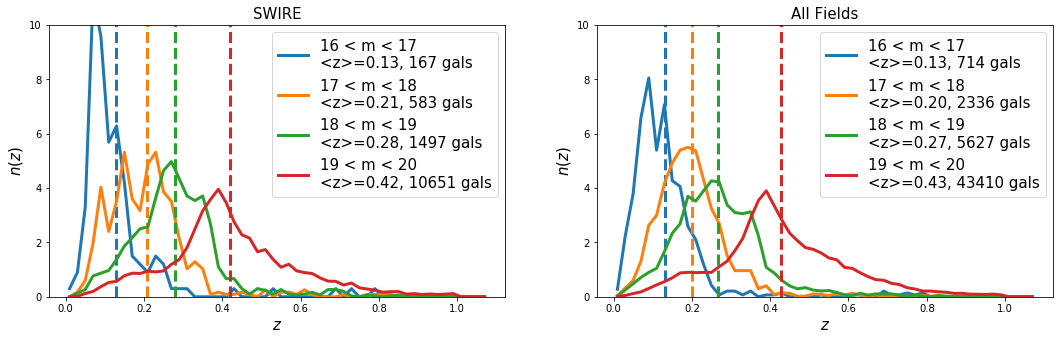

In [81]:
from astropy import units as u
from ciber_info import *

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

dz = 0.02
binedges = np.arange(0,1.1,dz)
bins = (binedges[1:] + binedges[:-1]) / 2

htot = np.zeros([4, len(bins)],dtype=int)

for i,ifield in enumerate([4,5,6,7,8]):
    field = fieldnamedict[ifield]
    fname = mypaths['PScatdat']+ field + '.csv'
    df = pd.read_csv(fname)
    
    inst=1
    for im in range(4):
        m_min = im + 16
        m_max = im + 17
        dfi = df.loc[(df['sdssClass']==3) \
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['y'+str(inst)]>-0.5) & (df['y'+str(inst)]<1023.5)\
                    & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
                    & (df['I_comb']>=m_min) & (df['I_comb']<m_max)]
        Nall = len(dfi)
        dfi = dfi.loc[dfi['Photz']>0]
        f = len(dfi)/Nall

        z = np.array(dfi['Photz'])
        ra = np.array(dfi['ra'])
        dec = np.array(dfi['dec'])

        meanz = np.mean(z)
        medianz = np.median(z)
        h,_ = np.histogram(z, bins=binedges)
        htot[im,:] = htot[im,:] + h
        
        if ifield == 8:    
            ax[0].plot(bins, h/np.sum(h)/dz, lw=3, c='C'+str(im),
                      label='%d < m < %d\n'%(m_min,m_max) + \
                       r'<z>=%.2f'%meanz + ', %d gals'%len(z))
            ax[0].axvline(meanz,c='C'+str(im),ls='--', lw=3)
            ax[0].set_xlabel('$z$', fontsize=15)
            ax[0].set_title('%s'%field, fontsize=15)
            ax[0].legend(fontsize=15)
            ax[0].set_ylim([0,10])
            ax[0].set_ylabel('$n(z)$', fontsize=15)


for im in range(4):
    m_min = im + 16
    m_max = im + 17
    meanz=np.sum(htot[im,:]*bins)/np.sum(htot[im,:])
    ax[1].plot(bins, htot[im,:]/np.sum(htot[im,:])/dz, lw=3,  c='C'+str(im),
              label='%d < m < %d\n'%(m_min,m_max) + \
               r'<z>=%.2f'%meanz + ', %d gals'%np.sum(htot[im,:]))
    ax[1].axvline(meanz,c='C'+str(im),ls='--', lw=3)
ax[1].set_xlabel('$z$', fontsize=15)
ax[1].set_ylabel('$n(z)$', fontsize=15)
ax[1].set_title('All Fields', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].set_ylim([0,10])
plt.savefig('plots/z_kernel.png', dpi = 200, bbox_inches='tight')

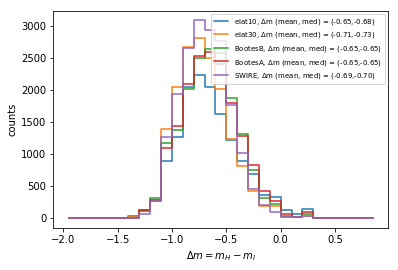

In [20]:
from astropy import units as u
from ciber_info import *

binedges = np.arange(-2,1,0.1)
bins = (binedges[1:] + binedges[:-1]) / 2

for i,ifield in enumerate([4,5,6,7,8]):
    field = fieldnamedict[ifield]
    fname = mypaths['PScatdat']+ field + '.csv'
    df = pd.read_csv(fname)
    dfi = df.loc[(df['sdssClass']==3) \
            & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
            & (df['y'+str(inst)]>-0.5) & (df['y'+str(inst)]<1023.5)\
            & (df['x'+str(inst)]>-0.5) & (df['x'+str(inst)]<1023.5)\
            & (df['I_comb']>=19.5) & (df['I_comb']<20.5)]

    I_arr = np.array(dfi['I_comb'])
    H_arr = np.array(dfi['H_comb'])
    h,_ = np.histogram(H_arr-I_arr, bins=binedges)
    plt.step(bins,h, where='mid',label='%s, $\Delta$m (mean, med) = (%.2f,%.2f)'%(field,
                                                    np.mean(H_arr-I_arr),np.median(H_arr-I_arr)))
plt.legend(fontsize=7)
plt.xlabel('$\Delta m = m_{H} - m_{I}$')
plt.ylabel('counts')
plt.savefig('/Users/ytcheng/Desktop/Dmask_mag.png', dpi = 150, bbox_inches='tight')

# mask radius - BG level test

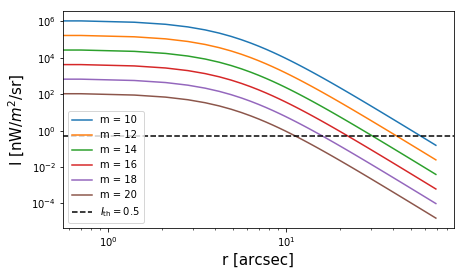

In [78]:
inst = 1
ifield = 8
m_arr = np.arange(10,21,2)
fitpsfdat=loadmat(mypaths['ciberdir'] + 'doc/20170617_Stacking/psf_analytic/TM'\
          + str(inst) + '/fitpsfdat.mat')['fitpsfdat'][0][ifield-1][7][0][0]
beta, rc, norm  = float(fitpsfdat[0]), float(fitpsfdat[1]), float(fitpsfdat[4])

Nlarge = 100
r_arr = np.arange(Nlarge)*0.7
Imap_large = norm * (1 + (r_arr/rc)**2)**(-3*beta/2)

lambdaeff = band_info(inst).wl
sr = ((7./3600.0)*(np.pi/180.0))**2
I_arr=3631*10**(-m_arr/2.5)*(3/lambdaeff)*1e6/(sr*1e9)

fig, ax = plt.subplots(1,1, figsize=(7,4))
for i,I in enumerate(I_arr):
    plt.loglog(r_arr, Imap_large*I*100, label='m = %d'%m_arr[i])
ax.axhline(0.5,c='k',ls='--', label=r'$I_{\rm th}=0.5$')
ax.set_xlabel('r [arcsec]', fontsize=15)
ax.set_ylabel('I [nW/$m^2$/sr]', fontsize=15)
ax.legend()
plt.savefig('/Users/ytcheng/Desktop/mask_rad.png', dpi = 100, bbox_inches='tight')

In [29]:
# from mask import *
# run_mask_rad_test(1,4)

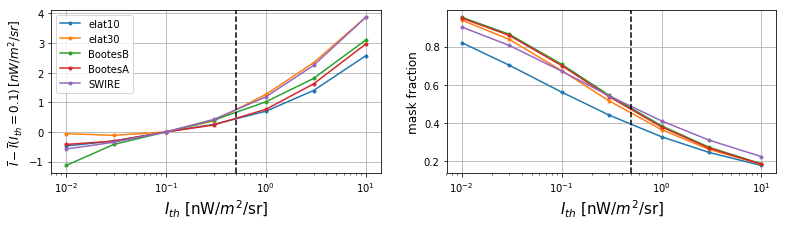

In [94]:
from utils_plotting import *

inst = 2
fig, ax = plt.subplots(1,2,figsize=(13,3))

for ifield in [4,5,6,7,8]:
    savename = './maskrad_test_data/maskrad_test_TM%d_%s'\
    %(inst, fieldnamedict[ifield])
    Ith_arr, meanmap_arr, maskf_arr = np.load(savename+'.npy')

    ax[0].semilogx(Ith_arr, meanmap_arr-meanmap_arr[4],'.-', label=fieldnamedict[ifield])
    ax[1].semilogx(Ith_arr, maskf_arr,'.-')

ax[0].grid()
ax[0].axvline(0.5,c='k',ls='--')
ax[0].set_xlabel('$I_{th}$ [nW/$m^2$/sr]', fontsize=15)
ax[0].set_ylabel(r'$\overline{I}-\overline{I}(I_{th}=0.1)\, [nW/m^2/sr]$', fontsize=12)
ax[0].legend()
ax[1].grid()
ax[1].axvline(0.5,c='k',ls='--')
ax[1].set_xlabel('$I_{th}$ [nW/$m^2$/sr]', fontsize=15)
ax[1].set_ylabel('mask fraction', fontsize=12)

plt.savefig('/Users/ytcheng/Desktop/mask_rad_I.png', dpi = 150, bbox_inches='tight')